# LightGBM
### Modelo LightGBM utilizando apenas as variáveis categóricas da base de dados

In [546]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Dataframes

In [547]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar.csv', low_memory=False)

## Tratamento

In [548]:
df_public['hora_ref'] = np.int8(df_public['hora_ref'].str[11:13])
df_public['origem'] = df_public['origem'].astype('category')
df_public['destino'] = df_public['destino'].astype('category')

In [549]:

cat_columns = df_public.select_dtypes(['category']).columns
df_public[cat_columns] = df_public[cat_columns].apply(lambda x: x.cat.codes)

In [550]:
df_model = df_public[[
    'hora_ref',
    'origem',
    'destino',
    'prev_troca_cabeceira',
    'troca_cabeceira_hora_anterior',
    'espera'
]]

## Datasets de Treino e Teste

In [551]:
# Dataframe para envio na competição
df_test_final = df_model[df_model.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_model[~df_model.espera.isnull()]
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.20, random_state=42, stratify=y_train_inicial)

In [552]:
train_data_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=['origem','destino','prev_troca_cabeceira','troca_cabeceira_hora_anterior'])
validation_data_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=['origem','destino','prev_troca_cabeceira','troca_cabeceira_hora_anterior'])

## Parâmetros

In [553]:
param = {'num_leaves': 70, 'objective': 'binary', 'metric': 'auc'}

## Treino

In [555]:
num_round = 10
bst = lgb.train(param, train_data_lgb, num_round, valid_sets=[validation_data_lgb])

[LightGBM] [Info] Number of positive: 2949, number of negative: 166394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 169343, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017414 -> initscore=-4.032892
[LightGBM] [Info] Start training from score -4.032892


In [556]:
y_pred = bst.predict(X_test,num_iteration=bst.best_iteration)

In [557]:
print(f1_score(y_test.to_list(), np.int8(y_pred > 0.042).tolist(), average='binary'))

0.08946877912395154


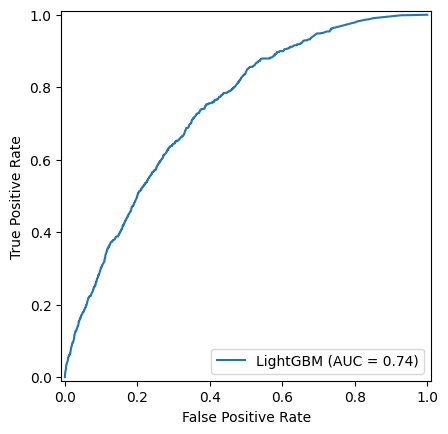

In [558]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='LightGBM')
display.plot()
plt.show()

## Teste e Submissão

In [559]:
sub = df_public[df_public.espera.isnull()].drop('espera',axis=1).flightid

In [560]:
threshold = 0.044

In [561]:
sub = pd.DataFrame(sub)
y_pred = bst.predict(df_test_final)
sub['espera'] = np.int8(y_pred > threshold)

In [562]:
(y_pred > threshold).any()
f'{sub.espera.sum()} de {sub.shape[0]} voos classificados como atrasados com threshold {threshold}'

'2295 de 90720 voos classificados como atrasados com threshold 0.044'

In [563]:
sub.to_csv('submission_lightgbm.csv',index=False)